<a href="https://colab.research.google.com/github/OANInternational/aguapp/blob/master/create_pump_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto para crear mapas y estudios a partir de las bases de datos de bombas

Hacer un google Drive un directorio

In [0]:
%cd

/root


In [3]:
%cd
%cd ..
%cd content

/root
/
/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls

drive  sample_data


In [3]:
%cd drive/'Team Drives'/'Comité de Infraestructuras, Energía y Agua'/'Proyectos'/'Red de Reparadores de Bombas Manuales'/'Prototipo Automatización'/

/content/drive/Team Drives/Comité de Infraestructuras, Energía y Agua/Proyectos/Red de Reparadores de Bombas Manuales/Prototipo Automatización


In [5]:
%cd 'Mapas'

/content/drive/Team Drives/Comité de Infraestructuras, Energía y Agua/Proyectos/Red de Reparadores de Bombas Manuales/Prototipo Automatización/Mapas


In [0]:
import yaml
spreadsheet_ids = yaml.load( open("parameters.yaml", "r" ))
#bombas de 2018, ultima version
ID1=str(spreadsheet_ids['ID1'])
#bombas de 2016, ultima version
ID2=str(spreadsheet_ids['ID2'])
#bombas de 2009, ultima version
ID3=str(spreadsheet_ids['ID3'])
#bombas final, datos de 2016 y 2009
ID4=str(spreadsheet_ids['ID4'])

GSHEET & GDRIVE AUTHETICATION

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
sheet_service = build('sheets', 'v4')

IMPORTS

In [0]:
import plotly
import plotly.plotly as py
import numpy as np


import matplotlib.pyplot as plt

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.dates
import seaborn as sns



Get Data in a spreadsheet with tasks and dates of project (starting and ending)

In [0]:
SPREADSHEET_ID = ID1
RANGE_NAME = 'Sheet1'

gsheet = sheet_service.spreadsheets().values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()

df_2019 = pd.DataFrame(gsheet.get('values', [])[1:],columns= gsheet.get('values', [])[0:1][0])

In [13]:
df_2019.head()

,Arrondissement,Village,Localite,Nom_Local,Longitude,Latitude,xCoord,yCoord,rqtListe_Pompe.Modele_Pompe
0,BIRO,BIRO,Biro,BIRO 2,"02°56'52.0""E","09°54'00.0""N",2.947778,9.9,VERGNET
1,BIRO,BIRO,Sarawondo,SARAWONDO,"02°58'29.2""E","09°54'13.2""N",2.974778,9.903666,VERGNET
2,BIRO,BIRO,Nallou,NANLOU,"02°54'30.2""E","09°56'00.0""N",2.908389,9.933333,VERGNET
3,BIRO,BIRO,Biro,BIRO CENTRE,"02°56'26.3""E","09°54'10.0""N",2.940639,9.902778,None
4,BIRO,BIRO,Biro,BIRO CENTRE,"02°56'47.9""E","09°54'10.9""N",2.946639,9.903028,AFRIDEV


In [37]:
df_2019.groupby('Arrondissement',axis=0).min()

,Village,Localite,Nom_Local,Longitude,Latitude,xCoord,yCoord,rqtListe_Pompe.Modele_Pompe,Latitude_decimals,Longitude_decimals
Arrondissement,,,,,,,,,,
BIRO,BIRO,Banon,BAANON,"02°46'50.0""E","09°50'00.0""N",2.780555,9.833333,ABI,9.833333,2.780556
GNONKOURAKALI,GBARI,Bassiarou,,"02°46'22.2""E","09°56'00.0""N",2.772833,10,AFRIDEV,9.933333,2.772833
NIKKI,BOUASSI,Alazi Kparou,,"03°06'03.2""E","09°07'25.7""N",3.100889,10.00028,ABI,9.123806,3.100889
OUENOU,FOMBAOUI,Assolè,,"03°15'37.8""E","09°50'00.0""N",3.2605,9.833333,AFRIDEV,9.833333,3.260500
SEREKALE,GANROU BARIBA,Alafiarou,,"02°58'35.1""E","09°53'02.7""N",2.976417,10.00361,AFRIDEV,9.884083,2.976417
SUYA,DAROUKPARA,Bantéré,BANTERE,"03°01'43.1""E","09°48'57.7""N",3.028639,9.816028,INDIA,9.816028,3.028639
TASSO,CHEIN,Bakou Tanakpé,,"02°53'20.5""E","09°39'17.7""N",2.889028,10.19672,ABI,9.654917,2.889028


In [15]:
df_2019.loc[0,'xCoord']

'2.947778'

In [16]:
df_2019.loc[0,'Longitude']

'02°56\'52.0"E'

In [17]:
import re
lat = df_2019.loc[0,'Longitude']
deg, minutes, seconds, direction =  re.split('[°\'"]', lat)
(float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

2.947777777777778

In [18]:
def decimals_lat(x):
  if x['Latitude']:
    if len(re.split('[°\'"]', x['Latitude'])) == 4 :
      deg, minutes, seconds, direction =  re.split('[°\'"]', x['Latitude'])
      lat=(float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
    elif len(re.split('[°\'"]', x['Latitude'])) > 0:
      lat=x['Latitude']
      print(lat)
  else:
    lat=None
    print(lat)
  return lat
df_2019['Latitude_decimals']=df_2019.apply(lambda x: decimals_lat(x),axis=1)

None
None


In [19]:
def decimals_lon(x):
  if x['Longitude']:
    if len(re.split('[°\'"]', x['Longitude'])) == 4 :
      deg, minutes, seconds, direction =  re.split('[°\'"]', x['Longitude'])
      lat=(float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
    elif len(re.split('[°\'"]', x['Longitude'])) > 0:
      lat=x['Longitude']
      print(lat)
  else:
    lat=None
    print(lat)
  return lat
df_2019['Longitude_decimals']=df_2019.apply(lambda x: decimals_lon(x),axis=1)

None
None


In [0]:
df_2019=df_2019.dropna()

In [0]:
#!apt-get install libgeos-3.5.0
#!apt-get install libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/master.zip

In [22]:
!pip install pyproj==1.9.6

     |████████████████████████████████| 2.8MB 6.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 2.2.1
    Uninstalling pyproj-2.2.1:
      Successfully uninstalled pyproj-2.2.1


In [0]:
from mpl_toolkits.basemap import Basemap
import folium
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches

In [0]:
df_count=df_2019[['Arrondissement','Village']].groupby('Arrondissement',axis=0).count()
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [182]:
df_count['Village']

Arrondissement
BIRO              25
GNONKOURAKALI     33
NIKKI            109
OUENOU            44
SEREKALE          42
SUYA              12
TASSO             36
Name: Village, dtype: int64

In [209]:
map_colors = {}
[map_colors.update({arron: colors[list(colors.keys())[i*3+8]]}) for i,arron in enumerate(df_count.index.tolist()) ]

[None, None, None, None, None, None, None]

In [210]:
map_colors

{'BIRO': '#F0F8FF',
 'GNONKOURAKALI': '#7FFFD4',
 'NIKKI': '#FFE4C4',
 'OUENOU': '#0000FF',
 'SEREKALE': '#DEB887',
 'SUYA': '#D2691E',
 'TASSO': '#FFF8DC'}

In [0]:
data=df_2019
data['color']=data.apply(lambda x: map_colors[x['Arrondissement']],axis=1)

c

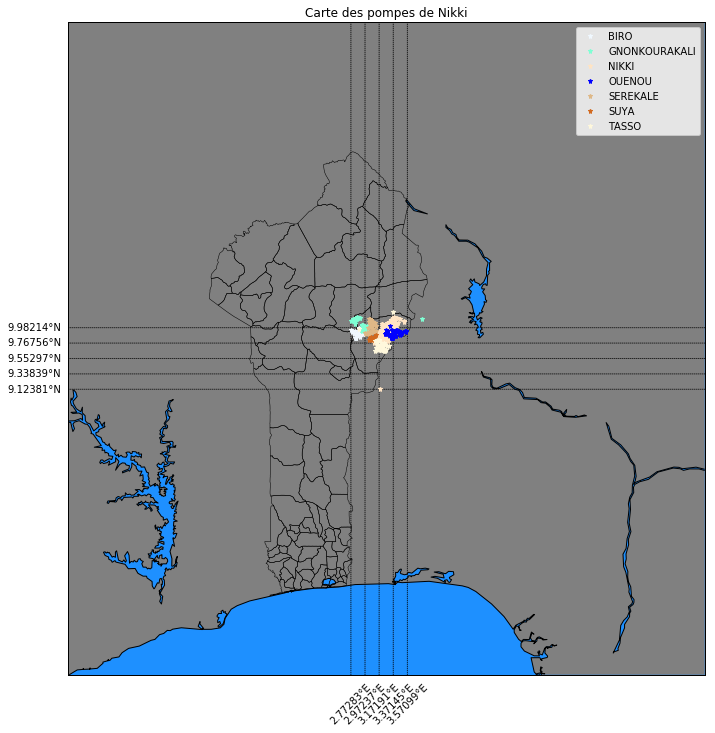

In [226]:

lat_begin=data['Latitude_decimals'].quantile(0.5)

lat_min=data['Latitude_decimals'].min()
lat_max=data['Latitude_decimals'].max()

lon_min=data['Longitude_decimals'].min()
lon_max=data['Longitude_decimals'].max()

lon_begin=data['Longitude_decimals'].quantile(0.5)
lats=np.array(data['Latitude_decimals'])
lons=np.array(data['Longitude_decimals'])
zoom_scale = 0

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
        np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

plt.figure(figsize=(25,12))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=lat_min-4,urcrnrlat=lat_max+4,\
            llcrnrlon=lon_min-4,urcrnrlon=lon_max+4,lat_ts=10,resolution='i')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='grey',lake_color='dodgerblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
m.drawmapboundary(fill_color='dodgerblue')
m.readshapefile('gadm36_BEN_shp/gadm36_BEN_2','NAME_2')
# build and plot coordinates onto map
for arron in df_count.index.tolist():
  data_arron=data[data['Arrondissement']==arron]
  lats=np.array(data_arron['Latitude_decimals'])
  lons=np.array(data_arron['Longitude_decimals'])
  x,y = m(lons,lats)
  m.plot(x,y,'r*',c=map_colors[arron],markersize=5,label=arron)
  
plt.legend()
  
plt.title("Carte des pompes de Nikki")
plt.savefig('carte_des_pompes_de_Niki_benin.png', format='png', dpi=500)
plt.show()

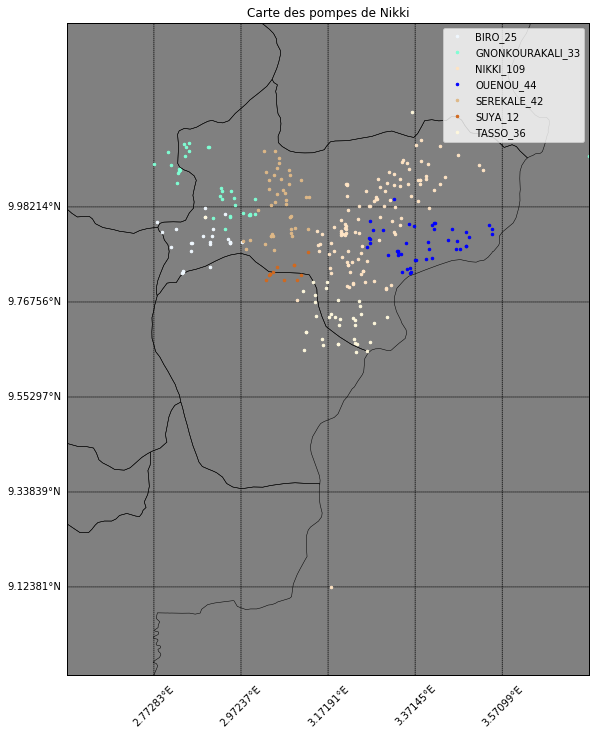

In [225]:
data=df_2019
lat_begin=data['Latitude_decimals'].quantile(0.5)

lat_min=data['Latitude_decimals'].min()
lat_max=data['Latitude_decimals'].max()

lon_min=data['Longitude_decimals'].min()
lon_max=data['Longitude_decimals'].max()

lon_begin=data['Longitude_decimals'].quantile(0.5)
lats=np.array(data['Latitude_decimals'])
lons=np.array(data['Longitude_decimals'])
zoom_scale = 0

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
        np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

plt.figure(figsize=(25,12))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=lat_min-0.2,urcrnrlat=lat_max+0.2,\
            llcrnrlon=lon_min-0.2,urcrnrlon=lon_max,lat_ts=10,resolution='i')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='grey',lake_color='dodgerblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
m.drawmapboundary(fill_color='dodgerblue')
m.readshapefile('gadm36_BEN_shp/gadm36_BEN_2','NAME_2')

# build and plot coordinates onto map
for arron in df_count.index.tolist():
  data_arron=data[data['Arrondissement']==arron]
  lats=np.array(data_arron['Latitude_decimals'])
  lons=np.array(data_arron['Longitude_decimals'])
  x,y = m(lons,lats)
  m.plot(x,y,'.',c=map_colors[arron],markersize=5,label=arron+'_'+str(len(data_arron)))
  
plt.legend()
plt.title("Carte des pompes de Nikki")
plt.savefig('carte_des_pompes_de_Niki_borgou.png', format='png', dpi=500)
plt.show()

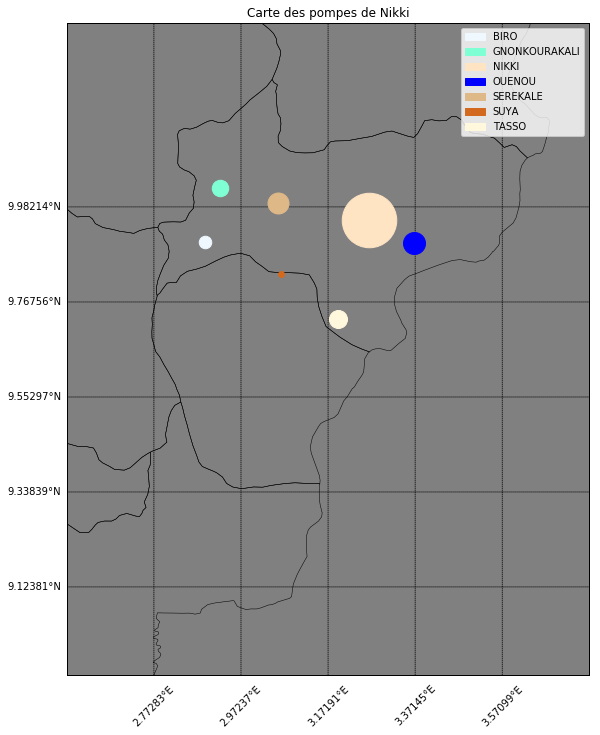

In [224]:
data=df_2019
lat_begin=data['Latitude_decimals'].quantile(0.5)

lat_min=data['Latitude_decimals'].min()
lat_max=data['Latitude_decimals'].max()

lon_min=data['Longitude_decimals'].min()
lon_max=data['Longitude_decimals'].max()

lon_begin=data['Longitude_decimals'].quantile(0.5)
lats=np.array(data['Latitude_decimals'])
lons=np.array(data['Longitude_decimals'])
zoom_scale = 0

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
        np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

plt.figure(figsize=(25,12))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=lat_min-0.2,urcrnrlat=lat_max+0.2,\
            llcrnrlon=lon_min-0.2,urcrnrlon=lon_max,lat_ts=10,resolution='i')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='grey',lake_color='dodgerblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
m.drawmapboundary(fill_color='dodgerblue')
m.readshapefile('gadm36_BEN_shp/gadm36_BEN_2','NAME_2')
handlers =[]
# build and plot coordinates onto map
for arron in df_count.index.tolist():
  data_arron=data[data['Arrondissement']==arron]
  lats=np.array(data_arron['Latitude_decimals'].quantile(0.5))
  lons=np.array(data_arron['Longitude_decimals'].quantile(0.5))
  size=df_count.loc[arron,'Village']
  x,y = m(lons,lats)
  m.plot(x,y,'.',c=map_colors[arron],markersize=size)
  handlers.append(mpatches.Patch(color=map_colors[arron], label=arron))
  
plt.legend(handles=handlers)
plt.title("Carte des pompes de Nikki")
plt.savefig('carte_nombre_des_pompes_Nikki_borgou.png', format='png', dpi=500)
plt.show()

<BarContainer object of 15 artists>

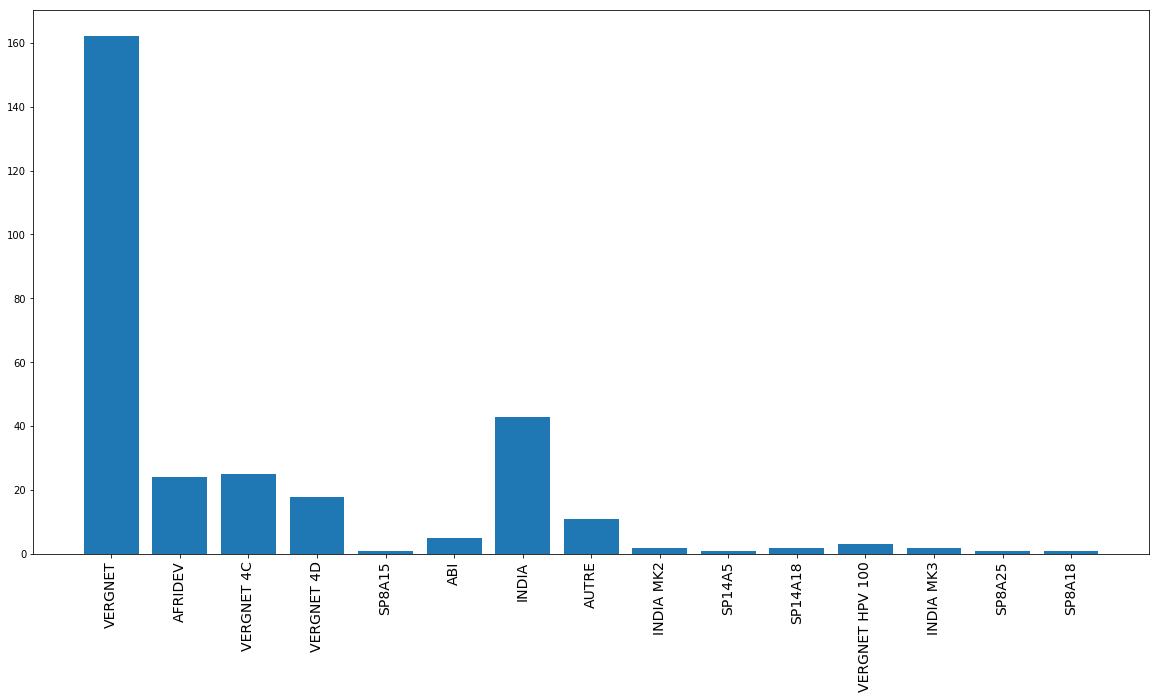

In [222]:
plt.rcParams['figure.figsize'] = 20,10
x=list(df_2019['rqtListe_Pompe.Modele_Pompe'].unique())
y=[df_2019[df_2019['rqtListe_Pompe.Modele_Pompe']==model]['rqtListe_Pompe.Modele_Pompe'].count() for model in x]

plt.xticks(fontsize=14,rotation=90)
plt.bar(x,y)

LEER EL SHAPEFILE DESCARAGO DE:

https://gadm.org/download_country_v3.html ->benin

In [0]:
import shapefile as shp

In [0]:
shp_path = 'gadm36_BEN_shp/gadm36_BEN_2.shp'
sf = shp.Reader(shp_path)

In [0]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [117]:
df = read_shapefile(sf)
df.shape

(76, 14)

In [118]:
df

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,coords
0,BEN,Benin,BEN.1_1,Alibori,,BEN.1.1_1,Banikoara,,,Commune,Commune,,BJ.AL.BA,"[(2.8467729091645424, 11.42146110534668), (2.8..."
1,BEN,Benin,BEN.1_1,Alibori,,BEN.1.2_1,Gogounou,,,Commune,Commune,,BJ.AL.GO,"[(2.2658329010010902, 10.54574203491211), (2.2..."
2,BEN,Benin,BEN.1_1,Alibori,,BEN.1.3_1,Kandi,,,Commune,Commune,,BJ.AL.KN,"[(3.273935079574642, 11.306771278381404), (3.2..."
3,BEN,Benin,BEN.1_1,Alibori,,BEN.1.4_1,Karimama,,,Commune,Commune,,BJ.AL.KR,"[(3.2918179035187904, 11.928750991821289), (3...."
4,BEN,Benin,BEN.1_1,Alibori,,BEN.1.5_1,Malanville,,,Commune,Commune,,BJ.AL.MA,"[(3.5912120342255776, 11.673298835754451), (3...."
5,BEN,Benin,BEN.1_1,Alibori,,BEN.1.6_1,Segbana,,,Commune,Commune,,BJ.AL.SE,"[(3.7127580642700764, 11.127946853637809), (3...."
6,BEN,Benin,BEN.2_1,Atakora,,BEN.2.1_1,Boukoumbé,Boukombé,,Commune,Commune,,BJ.AK.BO,"[(1.3887850046158974, 10.039131164550838), (1...."
7,BEN,Benin,BEN.2_1,Atakora,,BEN.2.2_1,Cobly,Cobli|Cobli,,Commune,Commune,,BJ.AK.CB,"[(0.897539973259029, 10.29423904418951), (0.88..."
8,BEN,Benin,BEN.2_1,Atakora,,BEN.2.3_1,Kérou,,,Commune,Commune,,BJ.AK.KE,"[(2.2658329010010902, 10.54574203491211), (2.2..."
9,BEN,Benin,BEN.2_1,Atakora,,BEN.2.4_1,Kouandé,,,Commune,Commune,,BJ.AK.KO,"[(1.3887850046158974, 10.039131164550838), (1...."
